In [1]:
%pylab inline --no-import-all
from __future__ import division

import pandas as pd
import seaborn as sns
import numpy as np

import time
import datetime
from datetime import datetime

import pytz
utc=pytz.UTC

import pyfolio as pf

figsize(13, 9)

Populating the interactive namespace from numpy and matplotlib


In [2]:
SPY = pf.utils.get_symbol_rets('SPY')
GLD = pf.utils.get_symbol_rets('GLD')
TLT = pf.utils.get_symbol_rets('TLT')
EEM = pf.utils.get_symbol_rets('EEM')
FXE = pf.utils.get_symbol_rets('FXE')
SPY.name = 'SPY'
GLD.name = 'GLD'
TLT.name = 'TLT'
EEM.name = 'EEM'
FXE.name = 'FXE'
stocks_str = ['SPY', 'GLD', 'TLT', 'EEM' , 'FXE']
stocks = [SPY, GLD, TLT, EEM, FXE]
stocks_df_na = pd.DataFrame(stocks).T
stocks_df_na.columns = stocks_str
stocks_df = stocks_df_na.dropna()

In [3]:
def portfolio_returns_metric_weighted(holdings_returns, exclude_non_overlapping=True, 
                                      weight_function=None, weight_function_window=None, inverse_weight=False, 
                                      portfolio_rebalance_rule='q', 
                                      weight_func_transform=None):
    
    """Generates an equal-weight portfolio, or portfolio weighted by weight_function

    Parameters
    ----------
    holdings_returns : list
       List containing each individual holding's daily returns of the
       strategy, noncumulative.

    exclude_non_overlapping : boolean, optional
       (Only applicable if equal-weight portfolio, e.g. weight_function=None)
       If True, timeseries returned will include values only for dates
       available across all holdings_returns timeseries If False, 0%
       returns will be assumed for a holding until it has valid data

    Returns
    -------
    (pd.Series, pd.DataFrame)
        pd.Series : Portfolio returns timeseries.
        pd.DataFrame : All the raw data used in the portfolio returns calculations
    """
    
    if weight_function is None:
        if exclude_non_overlapping:
            holdings_df = pd.DataFrame(holdings_returns).T.dropna()
        else:
            holdings_df = pd.DataFrame(holdings_returns).T.fillna(0)
        
        holdings_df['port_ret'] = holdings_df.sum(axis=1) / len(holdings_returns)    
    else:
        print "Weighting holdings by: " + str(weight_function)
        holdings_df_na = pd.DataFrame(holdings_returns).T
        holdings_cols = holdings_df_na.columns
        holdings_df = holdings_df_na.dropna()
        
        holdings_func = pd.rolling_apply(holdings_df, 
                                         window=weight_function_window, 
                                         func=weight_function).dropna()
        holdings_func_rebal = holdings_func.resample(rule=portfolio_rebalance_rule, 
                                                     how='last')
        holdings_df = holdings_df.join(holdings_func_rebal, rsuffix='_f').fillna(method='ffill').dropna()
        
        if weight_func_transform is None:
            holdings_func_rebal_t = holdings_func_rebal
            holdings_df = holdings_df.join(holdings_func_rebal_t, rsuffix='_t').fillna(method='ffill').dropna()
        else:
            holdings_func_rebal_t = holdings_func_rebal.applymap(weight_func_transform)
            holdings_df = holdings_df.join(holdings_func_rebal_t, rsuffix='_t').fillna(method='ffill').dropna()
        
        transform_columns = map(lambda x: x+"_t" , holdings_cols)
        
        if inverse_weight:
            print "Applying inverse weight..."
            inv_func = 1.0 / holdings_df[transform_columns]
            holdings_df_weights = inv_func / inv_func.sum(axis=1)
        else:
            holdings_df_weights = holdings_df[transform_columns] / holdings_df[transform_columns].sum(axis=1)
        
        holdings_df_weights.columns = holdings_cols
        holdings_df = holdings_df.join(holdings_df_weights, rsuffix='_w')
        
        holdings_df_weighted_rets = np.multiply(holdings_df[holdings_cols], holdings_df_weights)
        holdings_df_weighted_rets['port_ret'] = holdings_df_weighted_rets.sum(axis=1)
        holdings_df = holdings_df.join(holdings_df_weighted_rets, rsuffix='_wret')

    return holdings_df['port_ret'], holdings_df

In [4]:
# Simple quantizing function.
# This can be used to just transform an input std into a "bucket" value. 
# It's a simple way to say, for all volatilities between X and Y just treat them all the same, 
# namely as having volatility Y. 

def bucket_std(value, 
               bins=[0.12, 0.15, 0.18, 0.21], 
               max_default=0.24):
    
    annual_vol = value * np.sqrt(252)
    
    for i in bins:
        if annual_vol <= i:
            return i
        
    return max_default

In [5]:
# This function can be used to restrict volatility weighting of the lowest volatility asset versus the 
# highest volatility asset to a certain limit. E.g. Never allocate more than 2x to the lowest volatility asset.
# Easy way to do this is to round up all the asset volatilities that fall below a certain bound to a specified 
# "lower bound" and round down all of the asset volatilites that fall above a certain bound to a specified
# "upper bound" 

def min_max_vol_bounds(value, 
                   lower_bound=0.12, 
                   upper_bound=0.24):
    
    annual_vol = value * np.sqrt(252)
    
    if annual_vol < lower_bound:
        return lower_bound
    
    if annual_vol > upper_bound:
        return upper_bound
    
    return annual_vol

# Equal-weight Portfolio

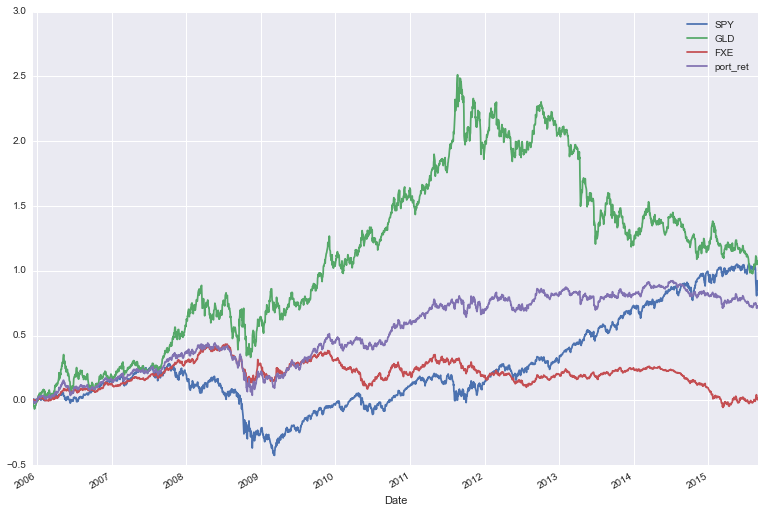

In [6]:
# USAGE: Equal-Weight Portfolio.
# 1) if 'exclude_non_overlapping=True' below, the portfolio will only contains 
#    days which are available across all of the algo return timeseries.
# 
#    if 'exclude_non_overlapping=False' then the portfolio returned will span from the
#    earliest startdate of any algo, thru the latest enddate of any algo.
#
# 2) Weight of each algo will always be 1/N where N is the total number of algos passed to the function

portfolio_rets_ts, data_df = portfolio_returns_metric_weighted([SPY, FXE, GLD],
                                                               exclude_non_overlapping=True
                                                              )
to_plot = ['SPY', 'GLD', 'FXE'] + ["port_ret"]
data_df[to_plot].apply(pf.timeseries.cum_returns).plot()

In [7]:
pf.timeseries.perf_stats(data_df['port_ret'])

,perf_stats
annual_return,0.064547
annual_volatility,0.120259
sharpe_ratio,0.536734
calmar_ratio,0.230711
stability,0.853869
max_drawdown,-0.279773
omega_ratio,1.097977
sortino_ratio,0.730478
skewness,-0.010997
kurtosis,5.783369


# Volatility-weighted Portfolio (using just np.std as weighting metric)

In [8]:
# USAGE: Portfolio based on volatility weighting.
# The higher the volatility the _less_ weight the algo gets in the portfolio
# The portfolio is rebalanced monthly. For quarterly reblancing, set portfolio_rebalance_rule='Q'


Weighting holdings by: <function std at 0x104c90a28>
Applying inverse weight...


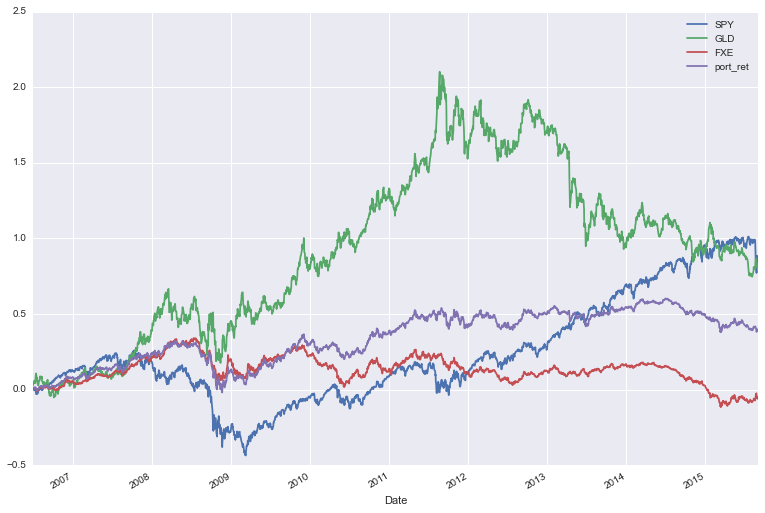

In [9]:
stocks_port, data_df = portfolio_returns_metric_weighted([SPY, FXE, GLD], 
                                                        weight_function=np.std, 
                                                        weight_function_window=126, 
                                                        inverse_weight=True)
to_plot = ['SPY', 'GLD', 'FXE'] + ["port_ret"]
data_df[to_plot].apply(pf.timeseries.cum_returns).plot()

In [10]:
pf.timeseries.perf_stats(data_df['port_ret'])

,perf_stats
annual_return,0.042121
annual_volatility,0.108210
sharpe_ratio,0.389252
calmar_ratio,0.162277
stability,0.753642
max_drawdown,-0.259562
omega_ratio,1.070656
sortino_ratio,0.535250
skewness,0.052587
kurtosis,4.754603


# Volatility-weighted Portfolio (with constraint of no asset weight to be greater than 2x any other asset weight. Function def min_max_vol_bounds defines the the constraint)

Weighting holdings by: <function std at 0x104c90a28>
Applying inverse weight...


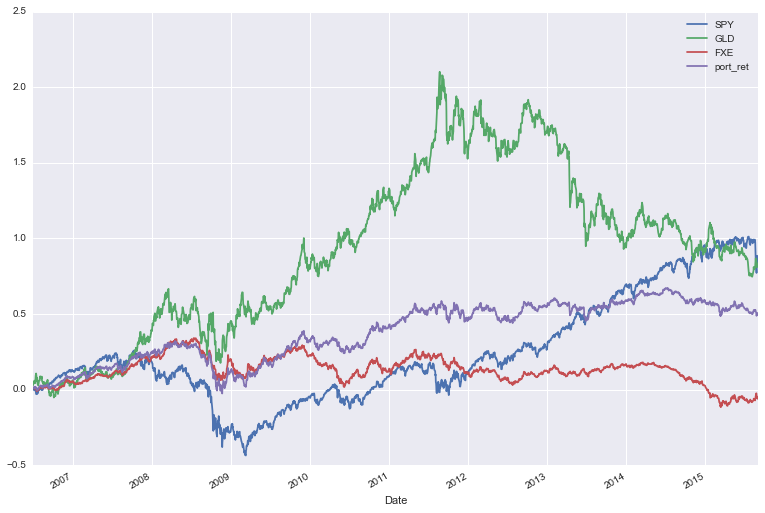

In [11]:
stocks_port, data_df = portfolio_returns_metric_weighted([SPY, FXE, GLD], 
                                                         weight_function=np.std,
                                                         weight_func_transform=min_max_vol_bounds,
                                                         weight_function_window=126, 
                                                         inverse_weight=True)
to_plot = ['SPY', 'GLD', 'FXE'] + ["port_ret"]
data_df[to_plot].apply(pf.timeseries.cum_returns).plot()

In [12]:
pf.timeseries.perf_stats(data_df['port_ret'])

,perf_stats
annual_return,0.051069
annual_volatility,0.112248
sharpe_ratio,0.454970
calmar_ratio,0.194282
stability,0.813157
max_drawdown,-0.262862
omega_ratio,1.082308
sortino_ratio,0.621291
skewness,-0.029981
kurtosis,4.570883


# Quantized bucket Volatility-weighted Portfolio (using custom function bucket_std() as weighting metric)

Weighting holdings by: <function std at 0x104c90a28>
Applying inverse weight...


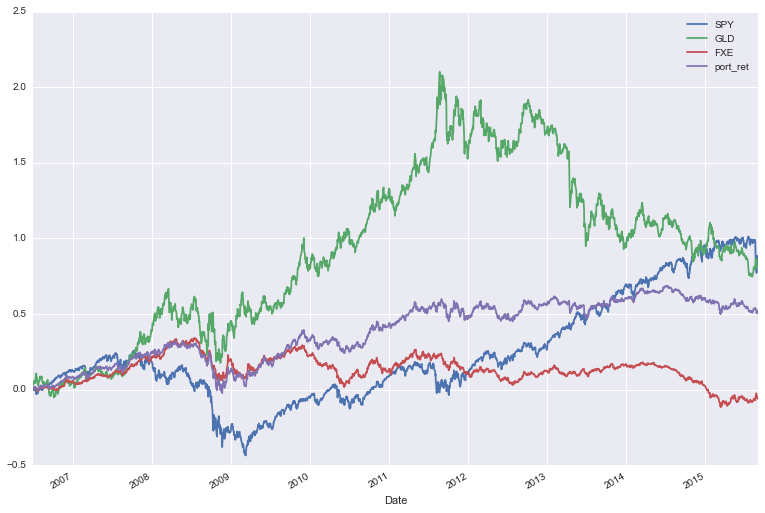

In [13]:
stocks_port, data_df = portfolio_returns_metric_weighted([SPY, FXE, GLD], 
                                                         weight_function=np.std,
                                                         weight_func_transform=bucket_std,
                                                         weight_function_window=126, 
                                                         inverse_weight=True)
to_plot = ['SPY', 'GLD', 'FXE'] + ["port_ret"]
data_df[to_plot].apply(pf.timeseries.cum_returns).plot()

In [14]:
pf.timeseries.perf_stats(data_df['port_ret'])

,perf_stats
annual_return,0.052076
annual_volatility,0.111812
sharpe_ratio,0.465744
calmar_ratio,0.199116
stability,0.819980
max_drawdown,-0.261535
omega_ratio,1.084269
sortino_ratio,0.637904
skewness,-0.009204
kurtosis,4.539253
